In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as DataLoader
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torch.utils.checkpoint import checkpoint

In [2]:
n_embd=768
mlp_dim=3072
patch_size=14
n_layers=6
n_heads=8
dropout=0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
data_train_dir='threePreprocessTrain_images/'
data_test_dir='threePreprocessTest_images/'

In [4]:
print(os.listdir(data_train_dir))
num_classes=len(os.listdir(data_train_dir))

print(os.listdir(data_test_dir))
num_classes2=len(os.listdir(data_test_dir))

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [7]:
from torch.utils.data import random_split

# Assuming Traindataset and Testdataset are already defined

# Calculate the sizes for training and validation sets
train_size = int(0.8 * len(train_subset))
val_size = int(0.2 * len(train_subset))
test_size = len(test_dataset)

# Split the training set into train and validation
train_data, val_data = random_split(train_subset, [train_size, val_size])

# Convert Testdataset to a similar structure to random_split
test_data = test_dataset  # This keeps Testdataset as a Dataset object

# Print the sizes of the datasets
print(len(train_data), len(val_data))
print(len(test_data))


2560 640
6400


In [9]:
img ,label=train_data[1500]
print(img.shape)

torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].


Class: NonDemented , Label: 2


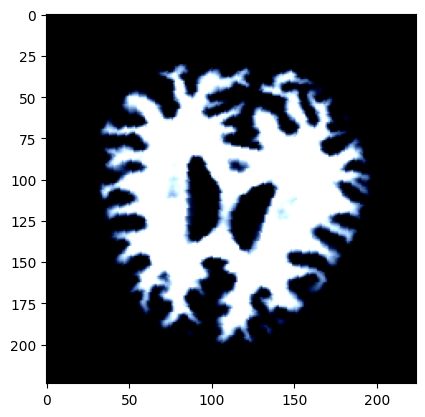

In [12]:
import matplotlib.pyplot as plt
print('Class:',train_dataset.classes[label],',','Label:',label)
plt.imshow(img.permute(1,2,0))


In [13]:
batch_size=128
train_dl=DataLoader(train_data,batch_size,shuffle=True)
val_dl=DataLoader(val_data,batch_size*2,shuffle=True)
test_dl=DataLoader(test_data,32,shuffle=False)

In [14]:
class PatchEmbeddings(nn.Module):
    def __init__(self,img_size,n_embd,patch_size):
        super().__init__()
        self.num_patches = (img_size // patch_size) ** 2
        self.patch=nn.Conv2d(3,n_embd,kernel_size=patch_size,stride=patch_size,padding=0)
        self.flatten=nn.Flatten(2,3)
    def forward(self,x):
        x=self.patch(x)
        x=self.flatten(x)
        return x.permute(0,2,1) 

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self,n_patches,n_embd):
        super().__init__()
        self.pos=nn.Parameter(torch.randn(1,n_patches+1,n_embd),requires_grad=True)
    def forward(self,x):
        return x+self.pos

In [16]:
class TransformerEncoder(nn.Module):
    def __init__(self,n_embd,n_heads,mlp_dim,dropout=dropout):
        super().__init__()
        self.l1=nn.LayerNorm(n_embd)
        self.l2=nn.LayerNorm(n_embd)
        self.attn=nn.MultiheadAttention(n_embd,n_heads,dropout=0,batch_first=True)
        self.mlp=nn.Sequential(
            nn.Linear(n_embd,mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim,n_embd),
            nn.Dropout(dropout)
        
        )
    def forward(self,x):
        x=self.l1(x)
        attn_out,_=self.attn(x,x,x)
        x=x+attn_out
        x=self.l2(x)
        mlp_out=self.mlp(x)
        x=x+mlp_out
        
        return x

In [17]:
class VisionTransformer(nn.Module):
    def __init__(self,img_size,num_classes,n_embd,patch_size,n_layers,n_heads,mlp_dim,dropout):
        super().__init__()
        self.patchify=PatchEmbeddings(img_size,n_embd,patch_size)
        self.n_patches=self.patchify.num_patches
        self.pos_encodings=PositionalEncoding(self.n_patches,n_embd)
        self.transformer_encoder=nn.ModuleList([TransformerEncoder(n_embd,n_heads,mlp_dim,dropout) for _ in range(n_layers)])
        self.cls_token=nn.Parameter(torch.randn(1,1,n_embd),requires_grad=True)
        self.mlp_head=nn.Sequential(
            nn.LayerNorm(n_embd),
            nn.Linear(n_embd,num_classes)
            
        )
    def forward(self,x):
        batch_size=x.shape[0]
        x=self.patchify(x)
        cls_tokens=self.cls_token.expand(batch_size,-1,-1)
        x=torch.cat([cls_tokens,x],dim=1)
        x=self.pos_encodings(x)

        for layer in self.transformer_encoder:
            x=checkpoint(layer,x,use_reentrant=False)
            
        cls_token_final=x[:,0]
        logits=self.mlp_head(cls_token_final)
        
        return logits

In [28]:
@torch.no_grad()
def evaluate(model,val_dl,criterion):
    model.eval()
    total=0
    correct=0
    batch_losses=[]
    for img,label in val_dl:
        img,label=img.to(device),label.to(device)
        logits = model(img)
        loss = criterion(logits, label)
        batch_losses.append(loss)
        _,predicted=torch.max(logits.data,1)
        total+=label.size(0)
        correct+=(predicted==label).sum().item()
    val_loss=torch.stack(batch_losses).mean()
    val_acc=(correct/total)*100
    return {'val_loss':val_loss,'val_acc':val_acc}

def train(n_epochs, lr_scheduler, model, train_dl, val_dl, criterion, optimizer):
    model.train()  # Set the model to training mode
    history = []
    
    for epoch in range(n_epochs):
        train_losses = []
        total = 0
        correct = 0
        
        for img, label in train_dl:
            img, label = img.to(device), label.to(device)
            
            optimizer.zero_grad()  # Zero gradients before backward pass
            logits = model(img)  # Forward pass
            loss = criterion(logits, label)  # Calculate loss
            train_losses.append(loss)
            
            # Get predictions
            _, predicted = torch.max(logits.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
            
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights
            
        # Step the learning rate scheduler (update learning rate)
        lr_scheduler.step()  # Adjust the learning rate after each epoch
        
        # Evaluate the model on validation data
        result = evaluate(model, val_dl, criterion)
        
        # Calculate training metrics
        train_loss = torch.stack(train_losses).mean()
        train_acc = (correct / total) * 100
        
        # Record results
        result['train_loss'] = train_loss
        result['train_acc'] = train_acc
        
        print(f'Epoch: {epoch}, train_loss: {result["train_loss"]}, train_acc: {result["train_acc"]}, val_loss: {result["val_loss"]}, val_acc: {result["val_acc"]}')
        history.append(result)
    
    return history


In [22]:
def initialize_weights(layer):
    if isinstance(layer, nn.Conv2d):
        nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.Linear):
        nn.init.xavier_normal_(layer.weight)
        if layer.bias is not None:
            nn.init.zeros_(layer.bias)
    elif isinstance(layer, nn.LayerNorm):
        nn.init.ones_(layer.weight)
        nn.init.zeros_(layer.bias)

In [23]:
model=VisionTransformer(224,num_classes,n_embd,patch_size,n_layers,n_heads,mlp_dim,dropout)
model.apply(initialize_weights)
model=model.to(device)

In [26]:
n_epochs = 20

# Define learning rate first
lr = 1e-4

# Initialize the AdamW optimizer with the correct learning rate
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

# Initialize the learning rate scheduler (StepLR)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Define the loss function
criterion = nn.CrossEntropyLoss()


In [30]:
pip install timm


  Using cached PyYAML-6.0.2-cp310-cp310-win_amd64.whl (161 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Collin Kliveson\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [32]:
pip install transformers


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Collin Kliveson\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [5]:
import torch

if torch.cuda.is_available():
    print(f"GPU is available: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available. Using CPU.")


GPU is available: NVIDIA GeForce RTX 4080 SUPER


In [7]:
pip install timm

Looking in indexes: https://pypi.org/simple/
  Using cached timm-1.0.15-py3-none-any.whl.metadata (52 kB)
  Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.1 kB)
  Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (3.8 kB)
Using cached timm-1.0.15-py3-none-any.whl (2.4 MB)
Using cached PyYAML-6.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (737 kB)
Using cached safetensors-0.5.3-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (471 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 MB 77.1 MB/s eta 0:00:00 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import torch
import random
import timm
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
from collections import defaultdict
import numpy as np
from torch.optim.lr_scheduler import StepLR
from PIL import Image, ImageFilter

# Paths to the datasets
train_data_dir = 'train'
val_data_dir = 'val'  # Not used here, as we split the undersampled train set

num_samples_per_class = 0.9

#if torch.cuda(isavaiable("print:"));
# Custom undersampled dataset
class UndersampledImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, target_transform=None, num_samples_per_class=None):
        super().__init__(root, transform=transform, target_transform=target_transform)
        self.num_samples_per_class = num_samples_per_class
        self.samples, self.targets = self.undersample()

    def undersample(self):
        class_indices = defaultdict(list)
        for idx, target in enumerate(self.targets):
            class_indices[target].append(idx)

        selected_indices = []
        for class_idx, indices in class_indices.items():
            total = len(indices)
            if isinstance(self.num_samples_per_class, float) and 0 < self.num_samples_per_class <= 1:
                num_to_sample = int(self.num_samples_per_class * total)
            elif isinstance(self.num_samples_per_class, int) and self.num_samples_per_class < total:
                num_to_sample = self.num_samples_per_class
            else:
                num_to_sample = total

            sampled_indices = random.sample(indices, num_to_sample)
            selected_indices.extend(sampled_indices)

        new_samples = [self.samples[idx] for idx in selected_indices]
        new_targets = [self.targets[idx] for idx in selected_indices]
        return new_samples, new_targets

# Custom transformation with noise removal and sharpening
class CustomTransform:
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.RandomRotation(20),
            transforms.RandomPerspective(distortion_scale=0.5, p=0.5, interpolation=3),
            transforms.Lambda(self.noise_removal),
            transforms.Lambda(self.sharpen_image),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, x):
        return self.transforms(x)

    def noise_removal(self, img):
        return img.filter(ImageFilter.GaussianBlur(radius=1))

    def sharpen_image(self, img):
        sharpness_filter = ImageFilter.UnsharpMask(radius=2, percent=150, threshold=3)
        return img.filter(sharpness_filter)

# Define transforms
train_transform = CustomTransform()
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load undersampled dataset
dataset = UndersampledImageFolder(root=train_data_dir, transform=train_transform, num_samples_per_class=num_samples_per_class)

# Split into train and val sets
train_size = int(0.7 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Class distribution printout
class_count = defaultdict(int)
for _, label in train_dataset:
    class_count[label] += 1
print(f"Class distribution after undersampling and splitting: {dict(class_count)}")

# Load model and prepare training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.head = nn.Linear(model.head.in_features, 4)  # For 4 disease classes
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
lr_scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

# Training loop
best_val_loss = np.inf
early_stopping_patience = 10
epochs_without_improvement = 0

for epoch in range(100):
    model.train()
    total_train_loss = 0
    total_train_correct = 0
    total_train_samples = 0

    for img, label in train_loader:
        img, label = img.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_train_correct += (predicted == label).sum().item()
        total_train_samples += label.size(0)

    epoch_train_loss = total_train_loss / len(train_loader)
    epoch_train_accuracy = 100 * total_train_correct / total_train_samples

    model.eval()
    total_val_loss = 0
    total_val_correct = 0
    total_val_samples = 0

    with torch.no_grad():
        for img, label in val_loader:
            img, label = img.to(device), label.to(device)
            outputs = model(img)
            loss = criterion(outputs, label)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_val_correct += (predicted == label).sum().item()
            total_val_samples += label.size(0)

    epoch_val_loss = total_val_loss / len(val_loader)
    epoch_val_accuracy = 100 * total_val_correct / total_val_samples

    print(f"Epoch {epoch+1}/100, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.2f}%, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.2f}%")

    lr_scheduler.step()

 
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= early_stopping_patience:
            print(f"Stopped at Epoch: {epoch+1}")
            break


Class distribution after undersampling and splitting: {3: 5607, 1: 4047, 2: 6054, 0: 5701}
Epoch 1/100, Train Loss: 1.2858, Train Acc: 37.78%, Val Loss: 1.3187, Val Acc: 42.49%
Epoch 2/100, Train Loss: 1.1107, Train Acc: 47.37%, Val Loss: 1.2399, Val Acc: 41.47%
Epoch 3/100, Train Loss: 1.0001, Train Acc: 53.47%, Val Loss: 0.8792, Val Acc: 59.76%
Epoch 4/100, Train Loss: 0.9126, Train Acc: 57.54%, Val Loss: 0.8686, Val Acc: 60.31%
Epoch 5/100, Train Loss: 0.8620, Train Acc: 59.93%, Val Loss: 0.8037, Val Acc: 63.08%
Epoch 6/100, Train Loss: 0.8357, Train Acc: 60.56%, Val Loss: 0.9722, Val Acc: 57.94%
Epoch 7/100, Train Loss: 0.8022, Train Acc: 62.79%, Val Loss: 0.9832, Val Acc: 55.88%
Epoch 8/100, Train Loss: 0.7794, Train Acc: 64.11%, Val Loss: 0.7960, Val Acc: 62.67%
Epoch 9/100, Train Loss: 0.7631, Train Acc: 64.73%, Val Loss: 0.7686, Val Acc: 65.12%
Epoch 10/100, Train Loss: 0.7473, Train Acc: 66.01%, Val Loss: 0.7520, Val Acc: 65.78%
Epoch 11/100, Train Loss: 0.6785, Train Acc: 69.

In [20]:
# Save the model after training is finished
torch.save(model.state_dict(), 'trained_model.pth')

In [6]:
pip install timm

     ---------------------------------------- 0.0/52.0 kB ? eta -:--:--
     -------------- ----------------------- 20.5/52.0 kB 330.3 kB/s eta 0:00:01
     -------------------------------------  51.2/52.0 kB 435.7 kB/s eta 0:00:01
     -------------------------------------- 52.0/52.0 kB 444.5 kB/s eta 0:00:00
     ---------------------------------------- 0.0/57.7 kB ? eta -:--:--
     ---------------------------------------- 57.7/57.7 kB 3.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.4 MB ? eta -:--:--
   - -------------------------------------- 0.1/2.4 MB 3.0 MB/s eta 0:00:01
   --- ------------------------------------ 0.2/2.4 MB 2.9 MB/s eta 0:00:01
   -------- ------------------------------- 0.5/2.4 MB 3.8 MB/s eta 0:00:01
   --------------- ------------------------ 0.9/2.4 MB 4.7 MB/s eta 0:00:01
   ------------------------ --------------- 1.4/2.4 MB 6.1 MB/s eta 0:00:01
   ---------------------------------------  2.4/2.4 MB 8.3 MB/s eta 0:00:01
   --------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define the transformation for the validation data
val_transform = transforms.Compose([
    transforms.Resize(224),  # Resize to 224x224 for validation
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# Load the validation dataset (replace 'path_to_val_data' with the correct path)
val_data_dir = 'val'
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=val_transform)

# Create DataLoader for validation set
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [24]:
print(f"Predicted: {predicted}")
print(f"True labels: {label}")


Predicted: tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2])
True labels: tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3])


Class names: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


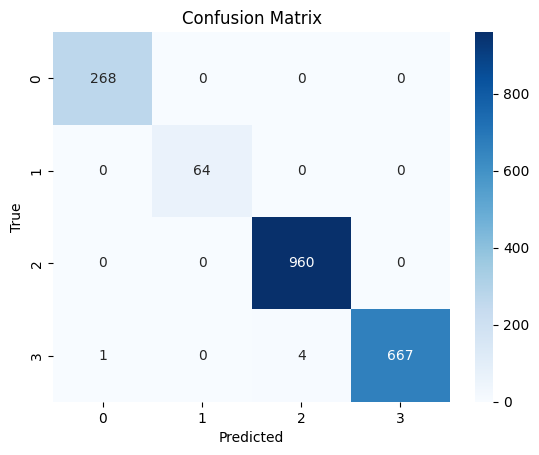

                  precision    recall  f1-score   support

    MildDemented       1.00      1.00      1.00       268
ModerateDemented       1.00      1.00      1.00        64
     NonDemented       1.00      1.00      1.00       960
VeryMildDemented       1.00      0.99      1.00       672

        accuracy                           1.00      1964
       macro avg       1.00      1.00      1.00      1964
    weighted avg       1.00      1.00      1.00      1964



In [ ]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import timm
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import random
from collections import defaultdict


model = timm.create_model('vit_base_patch16_224', pretrained=False)
model.head = torch.nn.Linear(model.head.in_features, 4)  

model.load_state_dict(torch.load('best_model.pth', map_location=torch.device('cpu')))  # Path to your trained model
model.to(torch.device("cpu"))
model.eval()


val_transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


val_data_dir = 'val'
val_dataset = datasets.ImageFolder(root=val_data_dir, transform=val_transform)

val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = val_dataset.classes  
print(f"Class names: {class_names}")  
moderate_demented_class_idx = class_names.index("ModerateDemented") 

class_indices = defaultdict(list)
for idx, target in enumerate(val_dataset.targets):
    class_indices[target].append(idx)


subset_indices = []

subset_indices.extend(class_indices[moderate_demented_class_idx])

for class_idx, indices in class_indices.items():
    if class_idx != moderate_demented_class_idx:
        sample_size = int(len(indices) * 0.30)  
        sampled_indices = random.sample(indices, sample_size)
        subset_indices.extend(sampled_indices)

# Create a Subset Dataset using the sampled indices
subset_val_dataset = torch.utils.data.Subset(val_dataset, subset_indices)

# Create DataLoader for the subset
subset_val_loader = DataLoader(subset_val_dataset, batch_size=32, shuffle=False)

all_preds = []
all_labels = []

# Step 5: Perform inference and gather predictions and true labels
with torch.no_grad():  
    for img, label in subset_val_loader:
        img, label = img.to(device), label.to(device)
        outputs = model(img)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())  # Save predictions
        all_labels.extend(label.cpu().numpy())  # Save true labels

# Step 6: Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Step 7: Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(4), yticklabels=range(4))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Print classification report
print(classification_report(all_labels, all_preds, target_names=val_dataset.classes))


In [30]:
accuracy = (np.array(all_preds) == np.array(all_labels)).mean()
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 99.75%


In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')


Precision: 0.9975
Recall: 0.9975
F1-Score: 0.9975


In [32]:
from sklearn.metrics import roc_auc_score

# Compute the probability scores for each class
probabilities = []
all_labels_list = []  # Keep track of true labels as well

for img, label in val_loader:
    img = img.to(device)
    label = label.to(device)
    
    # Get model output and apply softmax to get probabilities
    outputs = model(img)
    probs = torch.softmax(outputs, dim=1).cpu().detach().numpy()
    
    probabilities.append(probs)
    all_labels_list.append(label.cpu().numpy())

# Flatten the list of probabilities and labels
probabilities = np.concatenate(probabilities, axis=0)
all_labels = np.concatenate(all_labels_list, axis=0)

# Compute ROC-AUC score for each class
roc_auc = roc_auc_score(all_labels, probabilities, multi_class='ovr')
print(f'ROC-AUC Score: {roc_auc:.4f}')


ROC-AUC Score: 1.0000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5877128].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5005665].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5702832

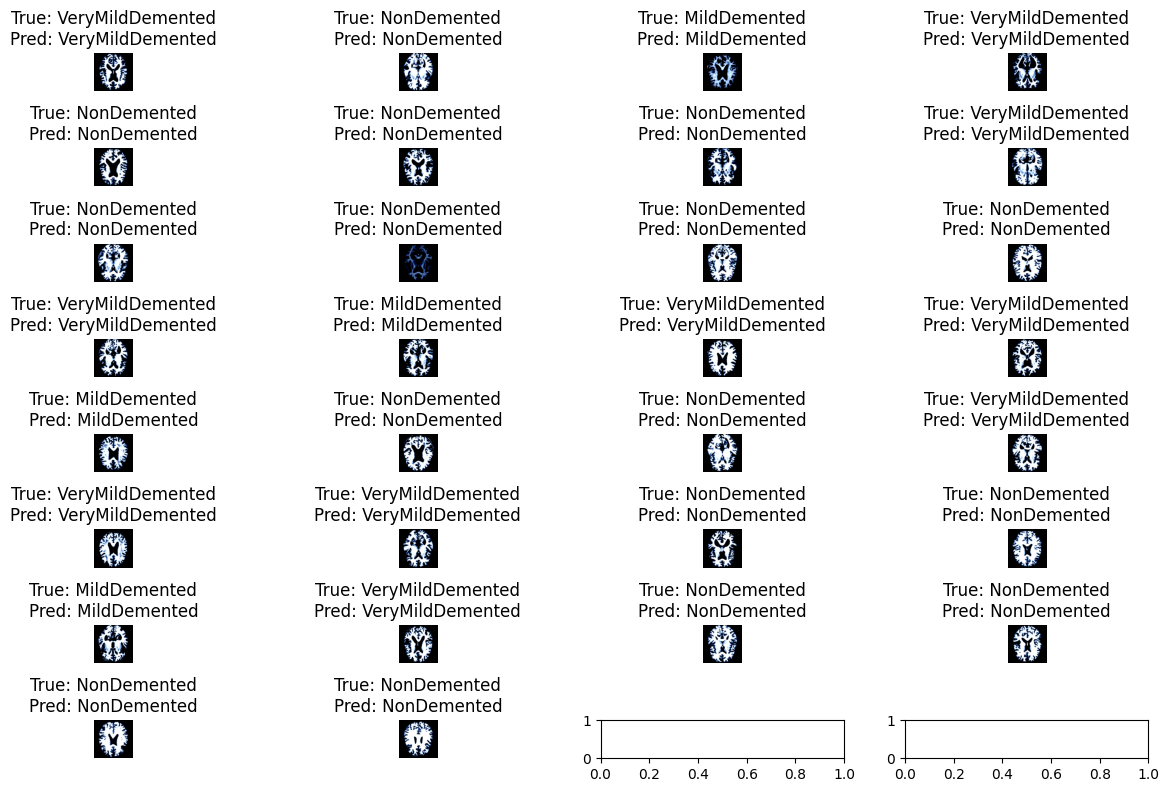

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch


test_data_dir = 'val'  


test_transform = transforms.Compose([
    transforms.Resize(224),  
    transforms.CenterCrop(224),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

# Load the testing dataset
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

# Create a DataLoader for the testing set with shuffle=True to randomize the order of images
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)  # Set shuffle=True to randomize

# Set model to evaluation mode
model.eval()

# Get a batch of testing data
data_iter = iter(test_loader)
images, labels = next(data_iter)  # Use next() instead of .next()

# Move images and labels to the device
images, labels = images.to(device), labels.to(device)

# Get predictions from the model
outputs = model(images)
_, preds = torch.max(outputs, 1)


images_per_row = 4
num_images = min(30, len(images))  

num_rows = num_images // images_per_row
if num_images % images_per_row != 0:
    num_rows += 1


fig, axes = plt.subplots(num_rows, images_per_row, figsize=(12, 8))

# Flatten the axes array to make indexing easier
axes = axes.flatten()

# Access the original test_dataset to get classes (subfolder names)
test_classes = test_dataset.classes  # Access the original ImageFolder classes (subfolder names)

for i in range(num_images):
    ax = axes[i]
    img = images[i].cpu().numpy().transpose(1, 2, 0)  # Convert to HWC format for displaying
    ax.imshow(img)
    ax.set_title(f'True: {test_classes[labels[i]]}\nPred: {test_classes[preds[i]]}')
    ax.axis('off')

# Adjust layout for better spacing and make sure everything fits
plt.tight_layout(pad=1.0)
plt.show()


Model 2: Patient Data

In [49]:
import pandas as pd

# Load the dataset
df = pd.read_csv('alzheimers_disease_data.csv')  # Adjust the path as needed

# Show the first few rows of the dataset
df.head()

# Check basic info and data types
df.info()

# Check for missing values
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

PatientID                    0
Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfu

In [50]:
# Summary statistics for numerical features
df.describe()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [51]:
# Drop the 'DoctorInCharge' column
df = df.drop(columns=['DoctorInCharge'])

# Check if the column is dropped
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,6.518877,0,0,1.725883,0,0,0,1,0,0
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,7.118696,0,0,2.592424,0,0,0,0,1,0
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,5.895077,0,0,7.119548,0,1,0,1,0,0
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,8.965106,0,1,6.481226,0,0,0,0,0,0
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,6.045039,0,0,0.014691,0,0,1,1,0,0


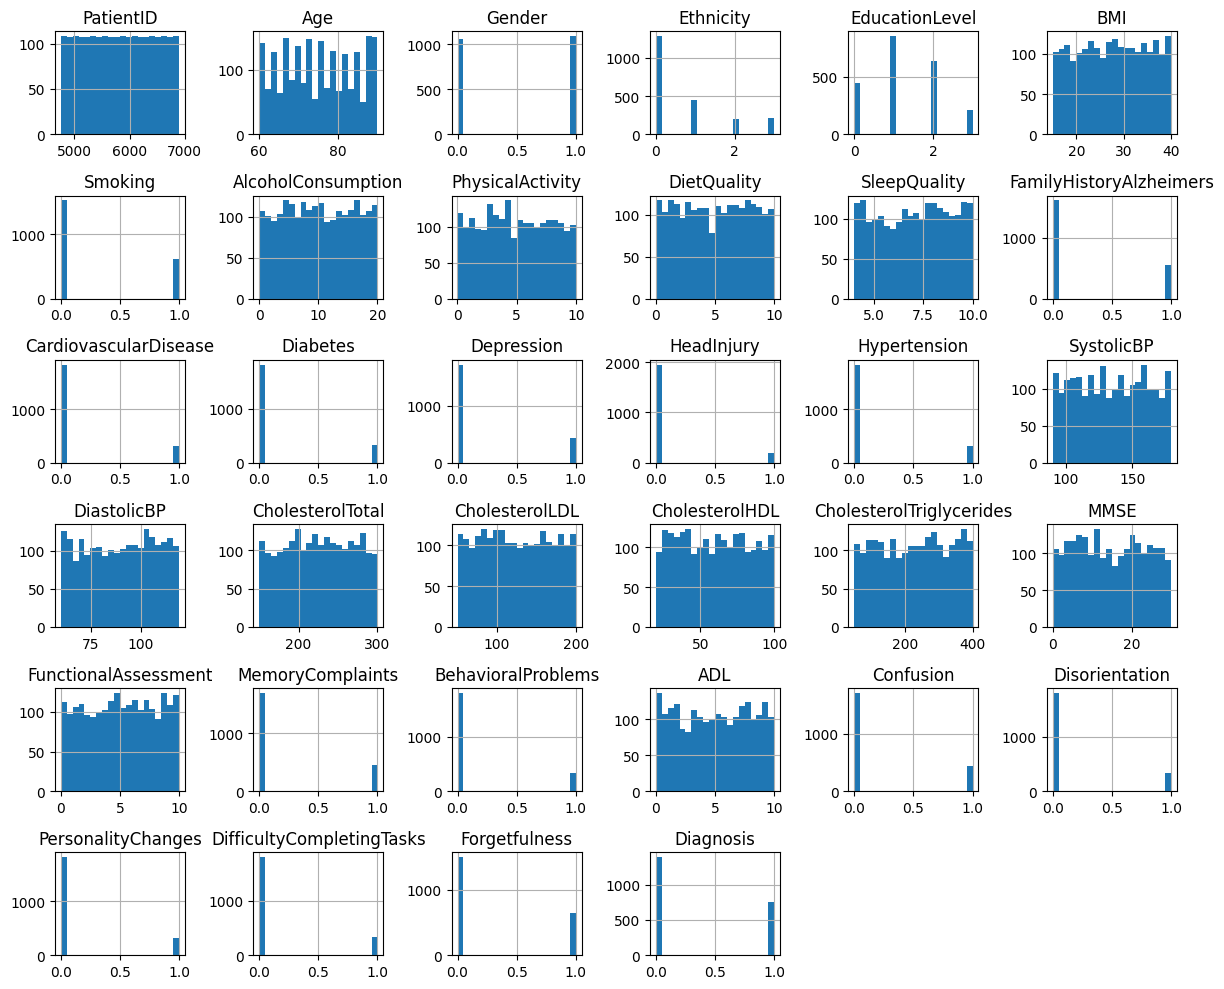

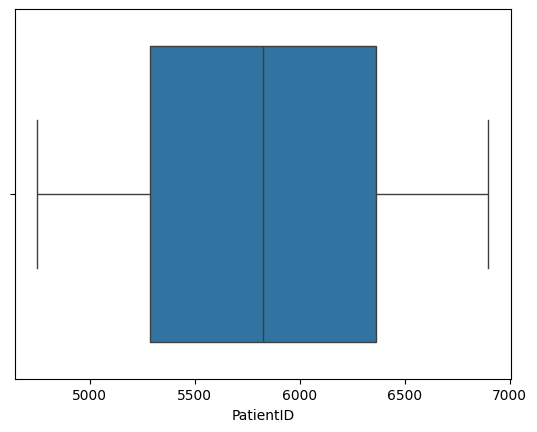

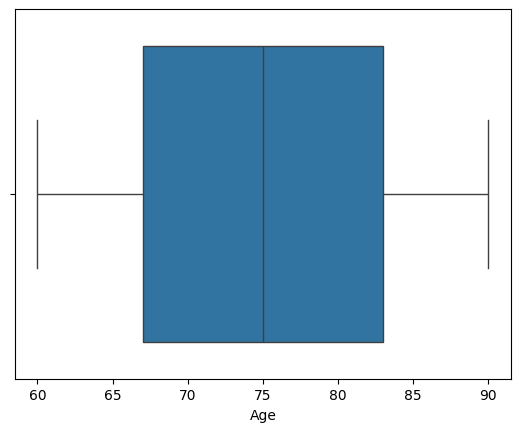

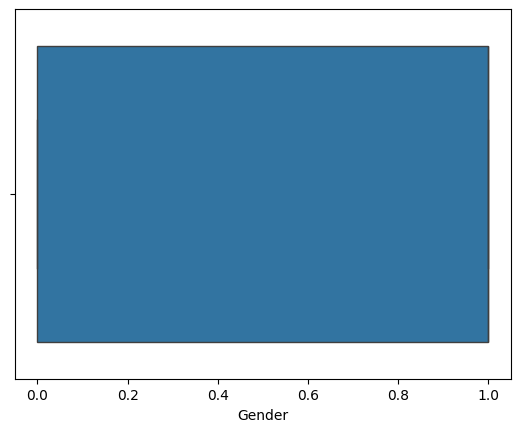

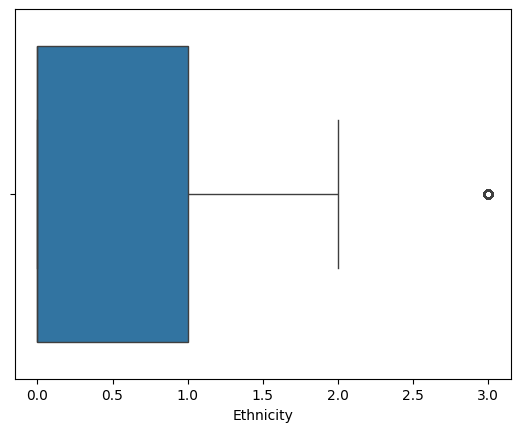

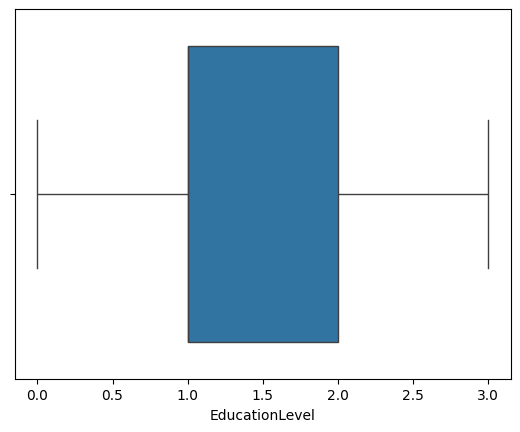

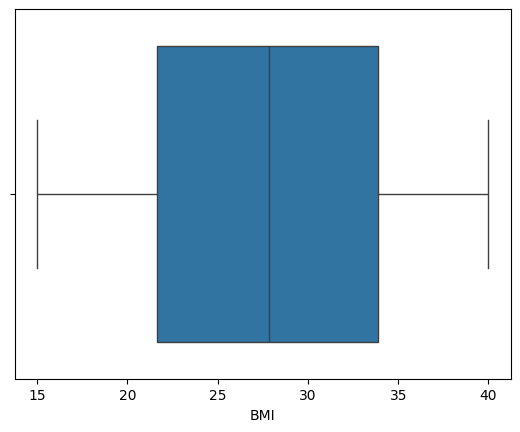

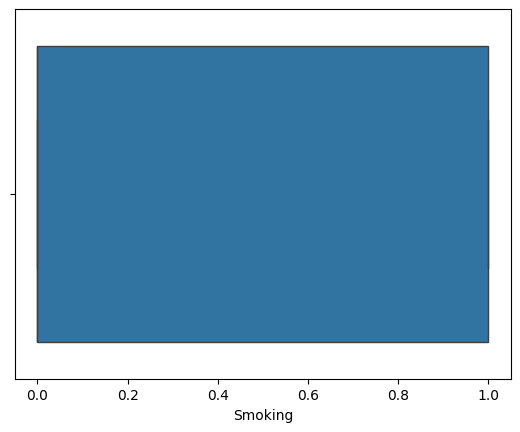

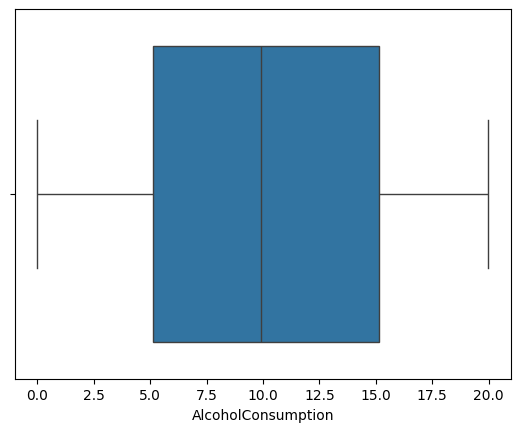

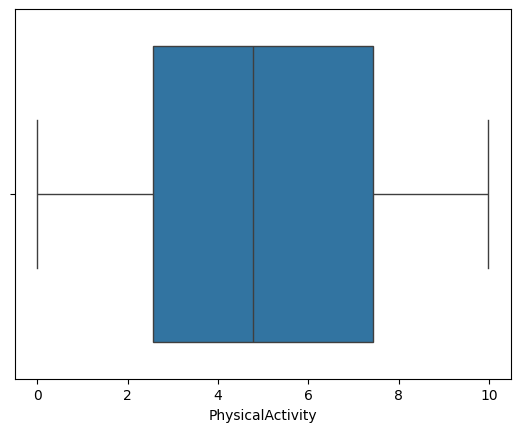

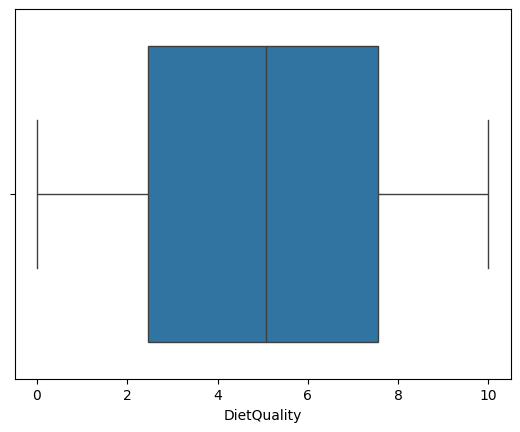

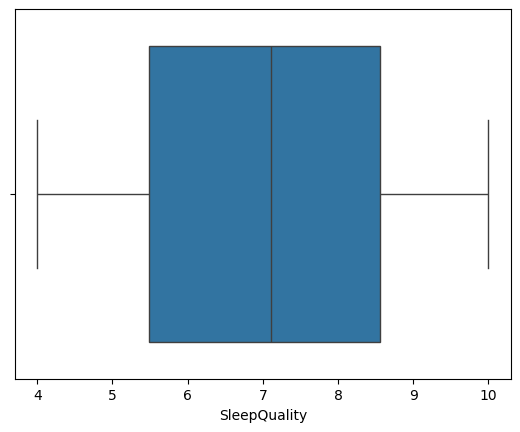

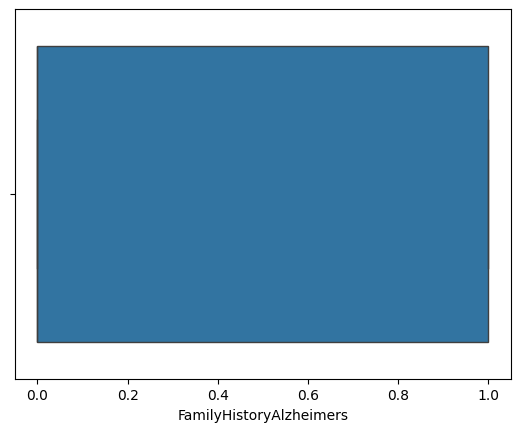

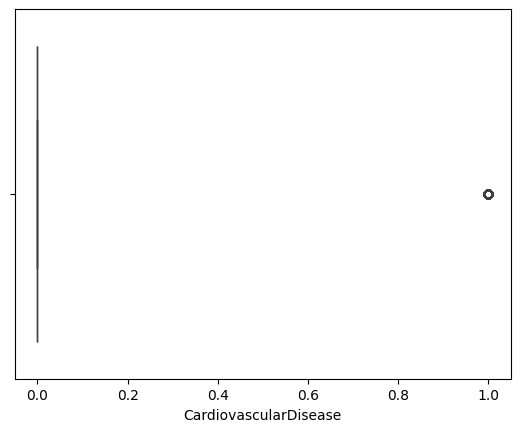

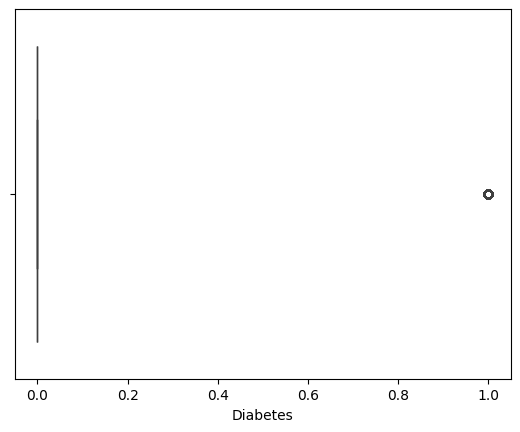

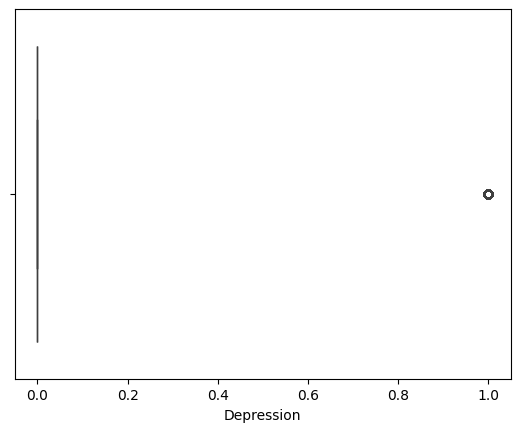

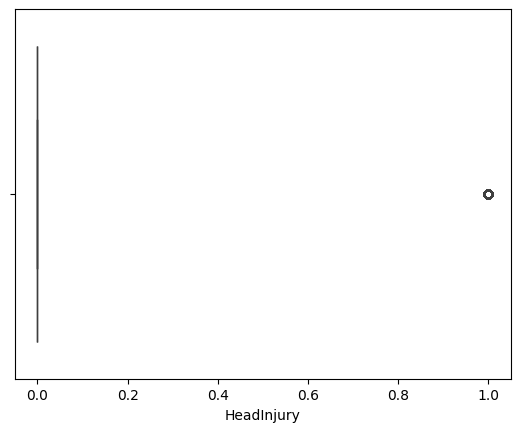

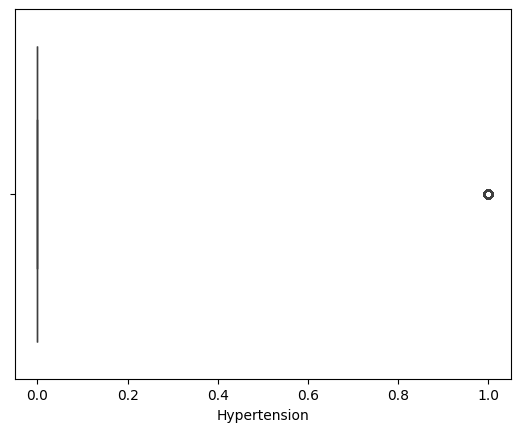

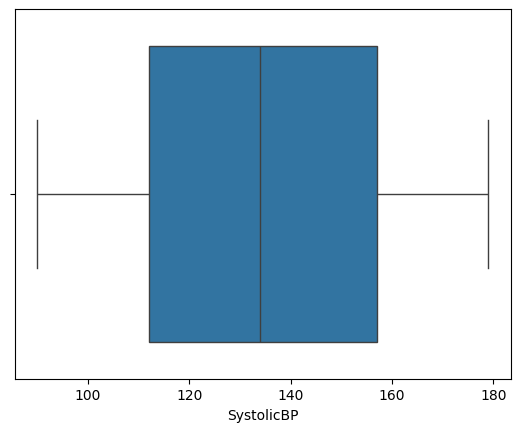

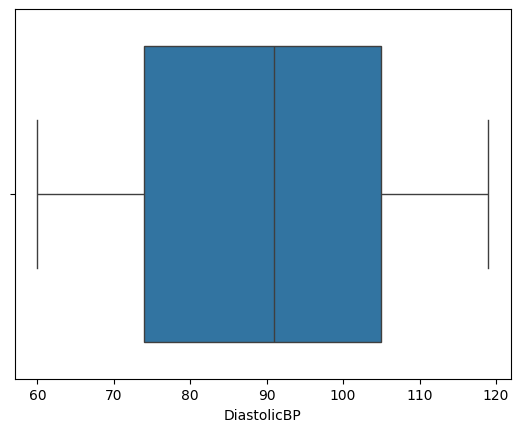

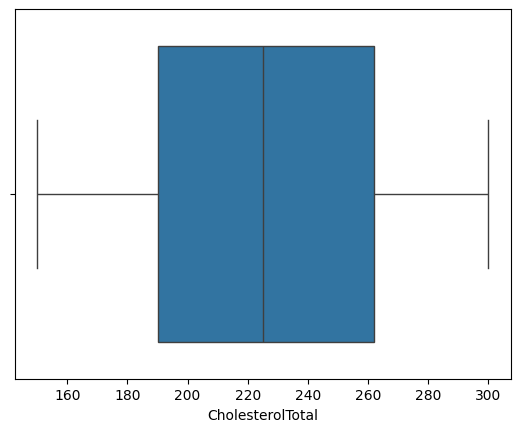

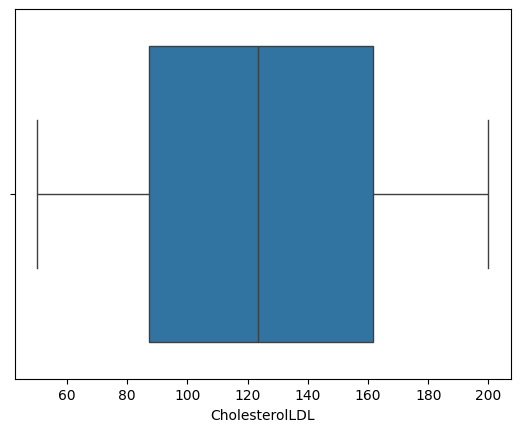

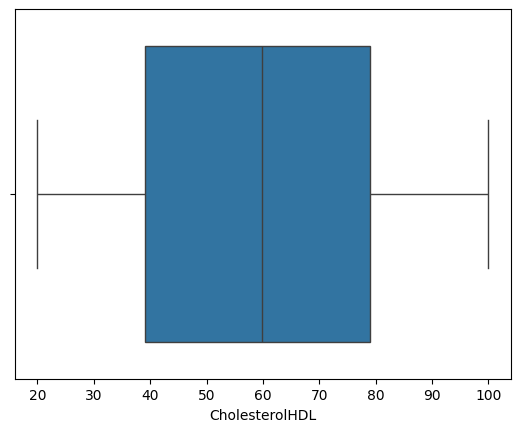

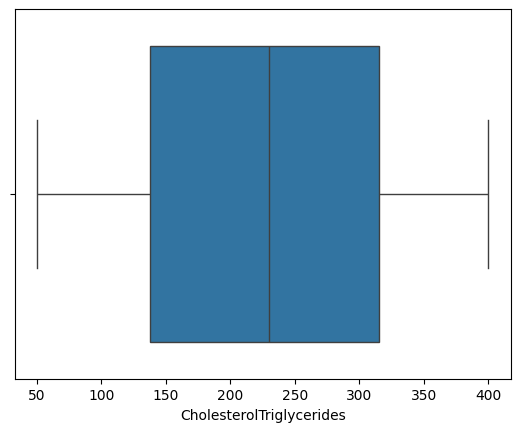

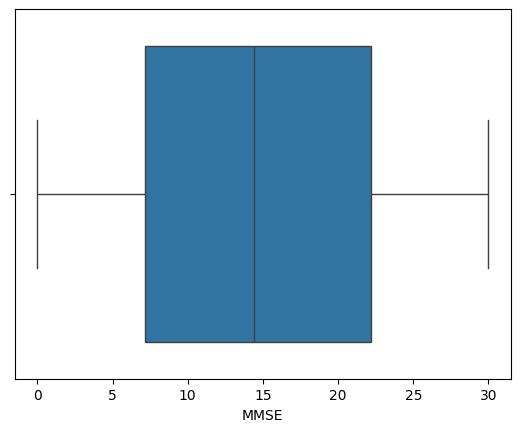

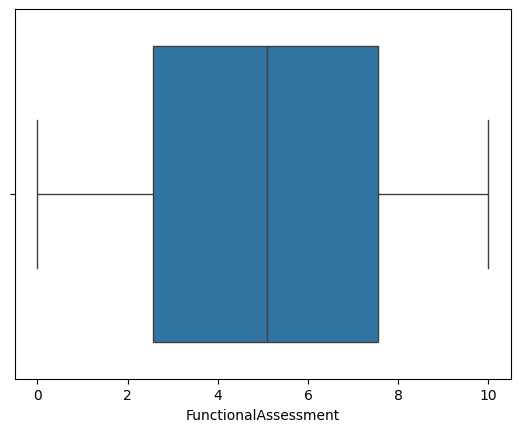

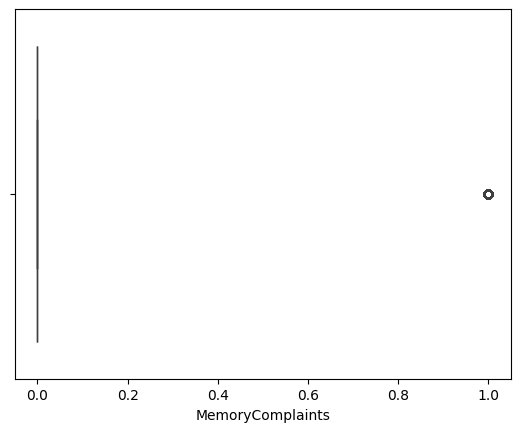

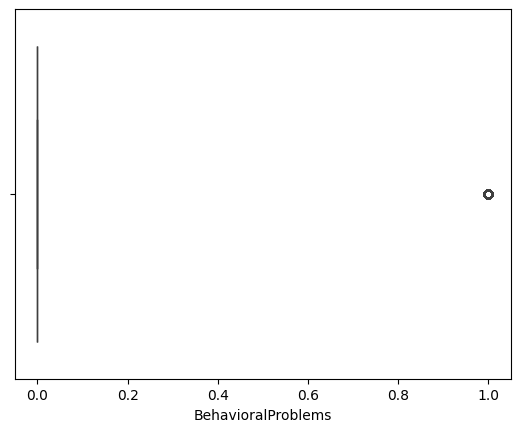

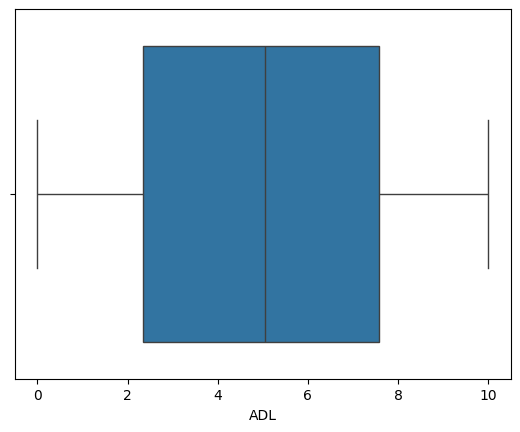

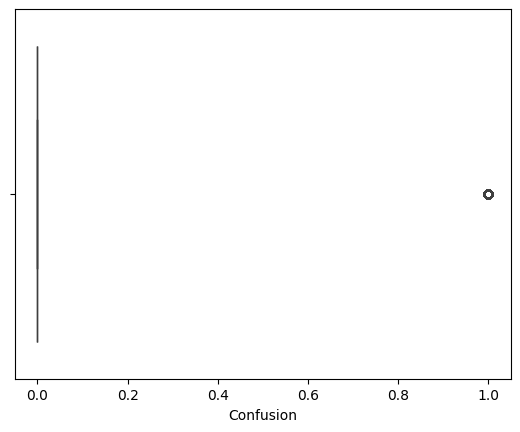

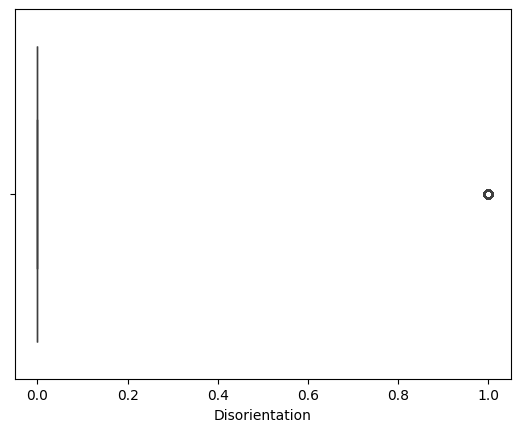

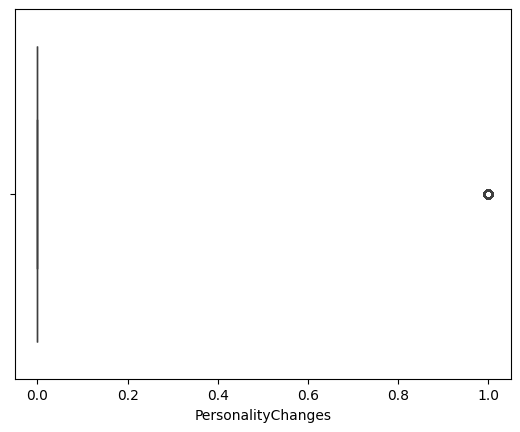

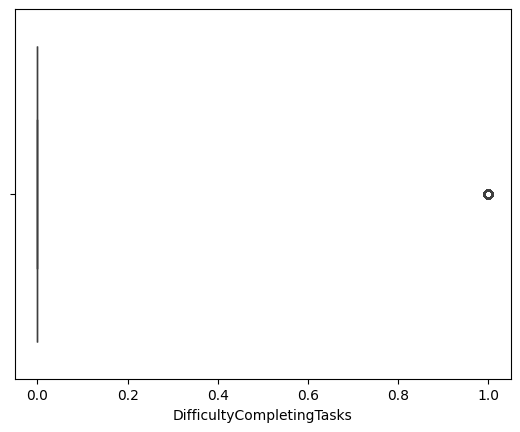

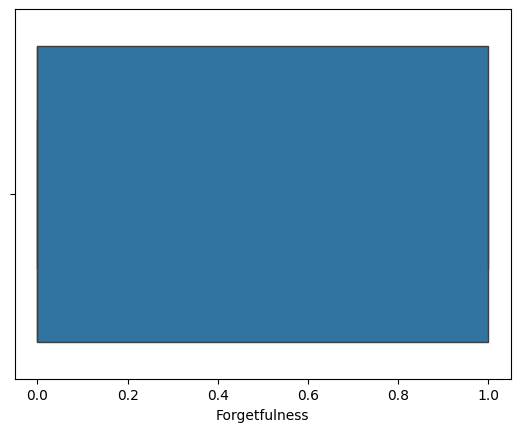

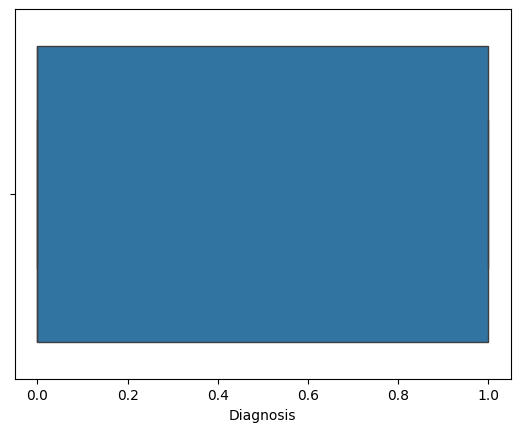

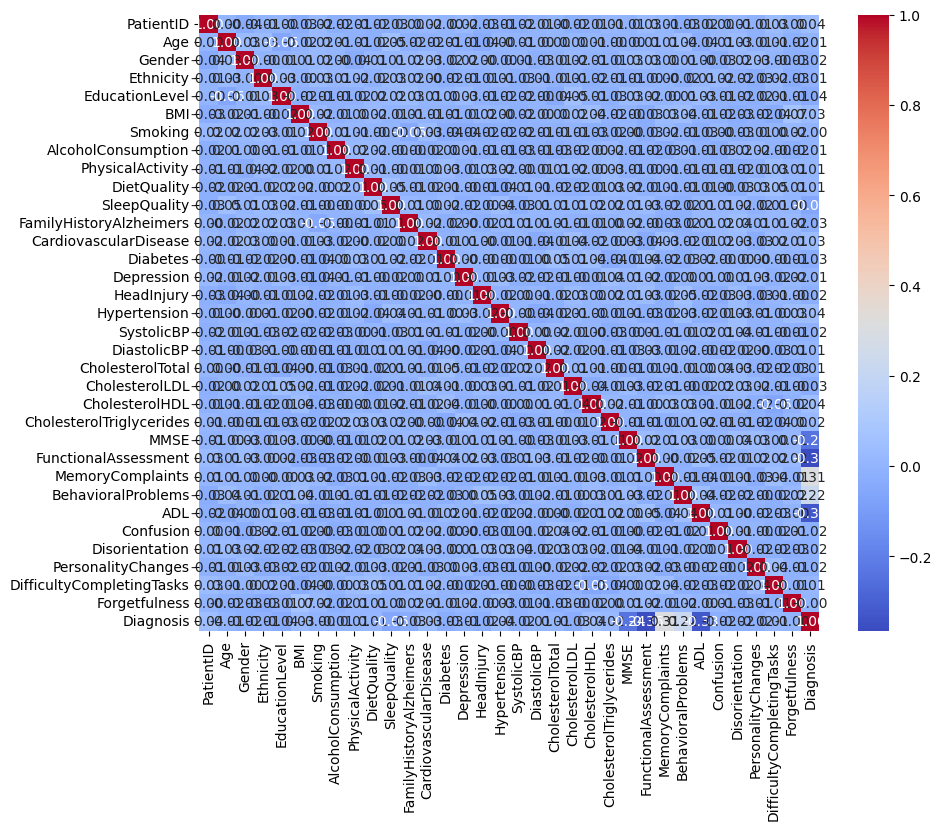

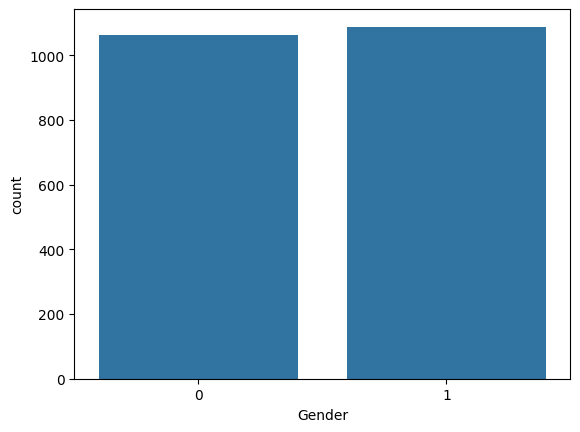

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt

# Histograms for numerical features
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

# Box plots for outliers in numerical features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    sns.boxplot(x=df[col])
    plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Bar plot for categorical features (e.g., Gender, Ethnicity, etc.)
sns.countplot(x='Gender', data=df)
plt.show()


FunctionalAssessment  Diagnosis               0.364898
Diagnosis             FunctionalAssessment    0.364898
ADL                   Diagnosis               0.330629
Diagnosis             ADL                     0.330629
                      MemoryComplaints        0.306742
MemoryComplaints      Diagnosis               0.306742
MMSE                  Diagnosis               0.236680
Diagnosis             MMSE                    0.236680
BehavioralProblems    Diagnosis               0.224350
Diagnosis             BehavioralProblems      0.224350
BMI                   Forgetfulness           0.071131
Forgetfulness         BMI                     0.071131
EducationLevel        Age                     0.060560
Age                   EducationLevel          0.060560
dtype: float64


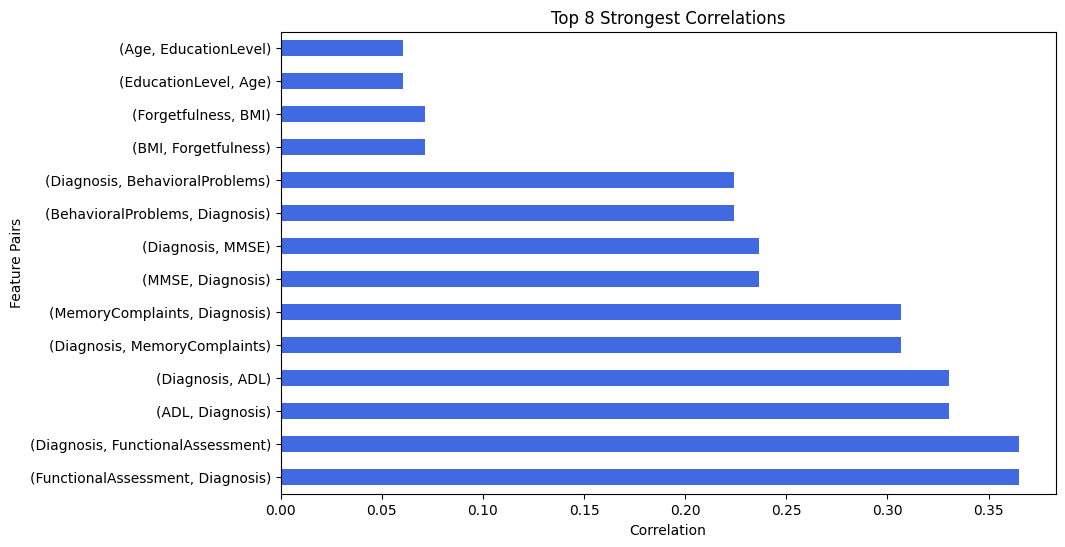

In [80]:
# Calculate the correlation matrix
correlation_matrix = df.corr()
# Unstack the correlation matrix to create a series of correlations
correlation_pairs = correlation_matrix.unstack()

# Sort the correlation pairs by absolute value, excluding self-correlations (correlation of a feature with itself)
sorted_pairs = correlation_pairs.abs().sort_values(ascending=False)

# Filter the top 5 pairs, ignoring the diagonal (self-correlations)
top_5_corr = sorted_pairs[sorted_pairs < 1].head(14)
print(top_5_corr)
# Plot the top 5 correlations as a bar plot
top_5_corr.plot(kind='barh', figsize=(10, 6), color='royalblue')
plt.xlabel('Correlation')
plt.ylabel('Feature Pairs')
plt.title('Top 8 Strongest Correlations')
plt.show()


In [94]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes                   2149 non-null   int64

In [ ]:
df = df.drop(columns=['Severity'])
df = df.drop(columns=['PatientID']) 


KeyError: "['Severity'] not found in axis"

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        2149 non-null   int64  
 1   Gender                     2149 non-null   int64  
 2   Ethnicity                  2149 non-null   int64  
 3   EducationLevel             2149 non-null   int64  
 4   BMI                        2149 non-null   float64
 5   Smoking                    2149 non-null   int64  
 6   AlcoholConsumption         2149 non-null   float64
 7   PhysicalActivity           2149 non-null   float64
 8   DietQuality                2149 non-null   float64
 9   SleepQuality               2149 non-null   float64
 10  FamilyHistoryAlzheimers    2149 non-null   int64  
 11  CardiovascularDisease      2149 non-null   int64  
 12  Diabetes                   2149 non-null   int64  
 13  Depression                 2149 non-null   int64

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch

# Drop Patient ID and Ethnicity from the features
X = df.drop(columns=['Ethnicity'])  # Exclude Patient ID and Ethnicity

# Features: Include all relevant features except Ethnicity and Patient ID
X = df[['Age', 'Gender', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 
       'PhysicalActivity', 'DietQuality', 'SleepQuality', 'FamilyHistoryAlzheimers', 
       'CardiovascularDisease', 'Diabetes', 'Depression', 'HeadInjury', 'Hypertension', 
       'SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 
       'CholesterolTriglycerides', 'MMSE', 'FunctionalAssessment', 'MemoryComplaints', 
       'BehavioralProblems', 'ADL', 'Confusion', 'Disorientation', 'PersonalityChanges', 
       'DifficultyCompletingTasks', 'Forgetfulness']]  # All relevant features

# Target: 'Diagnosis' or whatever outcome you're predicting
y = df['Diagnosis']

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize continuous features (e.g., ADL, MMSE, etc.)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)


In [101]:
pip install tabtransformers


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tabtransformers (from versions: none)
ERROR: No matching distribution found for tabtransformers

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
